# Loading in xray data from exp (55Fe x-rays on SCA 20663)

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import label
from scipy.ndimage import maximum_filter
from astropy.stats import sigma_clipped_stats
from concurrent.futures import ProcessPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.ndimage import label
from pathlib import Path

try:
    here = Path(__file__).parent
except NameError:
    # __file__ doesn't exist in notebooks or interactive sessions
    here = Path.cwd()
fits_path = here / '20190919_95k_1p1m0p1_fe55_20663_003_diff.fits'  # ← replace with your actual filename

with fits.open(fits_path) as hdulist:
    # hdulist is a list of HDU (Header/Data Unit) objects
    primary_hdu = hdulist[0]
    data = primary_hdu.data      # NumPy array of your image/spectrum/whatever
    header = primary_hdu.header  # FITS header metadata

print(f"Data shape: {data.shape}")
print("Header keys:", list(header.keys())[:10])


Data shape: (100, 4096, 4096)
Header keys: ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND']


In [2]:
def compute_mask_med_frame(data, sigma_mult):
    print("⏳ Computing median-frame mask…")
    median_img = np.median(data, axis=0)
    mad        = np.median(np.abs(median_img - np.median(median_img)))
    sigma_est  = 1.4826 * mad
    thresh_med = np.median(median_img) + sigma_mult * sigma_est
    mask_med   = median_img > thresh_med
    print(f"✅ Done median-frame mask (σ={sigma_est:.3f}, thresh={thresh_med:.1f})")
    return mask_med

def compute_mask_first_frame(data, sigma_mult):
    print("⏳ Computing first-slice mask…")
    first_img  = data[0]
    med_first  = np.median(first_img)
    mad_first  = np.median(np.abs(first_img - med_first))
    sigma_est  = 1.4826 * mad_first
    thresh0    = med_first + sigma_mult * sigma_est
    mask0      = first_img > thresh0
    print(f"✅ Done first-slice mask (σ={sigma_est:.3f}, thresh={thresh0:.1f})")
    return mask0

def compute_mask_saturation(data, sat_cut):
    print("⏳ Computing saturation-diff mask…")
    # If you wanted a row-wise tqdm you could replace the next line with a loop + tqdm
    frame_diff = np.abs(np.diff(data, axis=0))       # (Nframe-1, 4096,4096)
    med_diff   = np.median(frame_diff, axis=0)
    mask_sat   = med_diff < sat_cut
    print(f"✅ Done sat-diff mask (median(med_diff)={np.median(med_diff):.3e})")
    return mask_sat

# parameters
sigma_mult = 5.0
sat_cut     = 1e-3

# launch all three in parallel
with ThreadPoolExecutor() as exe:
    futures = {
        exe.submit(compute_mask_med_frame,  data, sigma_mult): 'med',
        exe.submit(compute_mask_first_frame, data, sigma_mult): 'first',
        exe.submit(compute_mask_saturation, data, sat_cut):     'sat',
    }
    # just iterate to let each print when done
    for fut in as_completed(futures):
        _name = futures[fut]
        # could inspect fut.result() here if you wanted to check for errors

# pull results out
mask_med = futures_inv = None
mask_med = futures_inv = None
mask_med = None
# unfortunately there's no built-in mapping back, so:
mask_med = [f for f,n in futures.items() if n=='med'][0].result()
mask0    = [f for f,n in futures.items() if n=='first'][0].result()
mask_sat = [f for f,n in futures.items() if n=='sat'][0].result()

print("🔗 Combining masks into one boolean array…")
maskArray = mask_med | mask0 | mask_sat
print("🎉 maskArray ready, shape =", maskArray.shape)

⏳ Computing median-frame mask…
⏳ Computing first-slice mask…
⏳ Computing saturation-diff mask…
✅ Done first-slice mask (σ=8.896, thresh=43.5)
✅ Done median-frame mask (σ=0.741, thresh=3.7)
✅ Done sat-diff mask (median(med_diff)=1.000e+01)
🔗 Combining masks into one boolean array…
🎉 maskArray ready, shape = (4096, 4096)


saturators =  29289
persistent warms =  107910
early saturators =  6


<IPython.core.display.Javascript object>


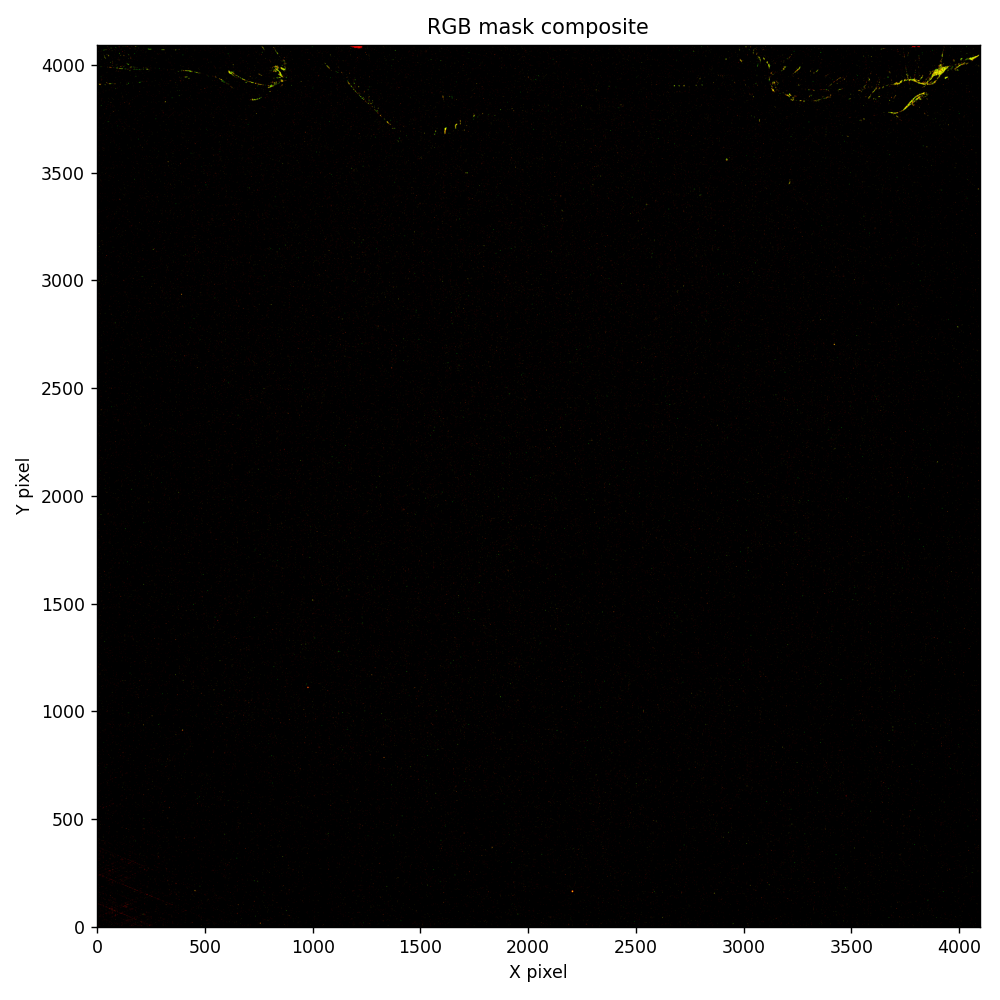

In [3]:
print("saturators = ", np.count_nonzero(mask0))
print("persistent warms = ", np.count_nonzero(mask_med))
print("early saturators = ", np.count_nonzero(mask_sat))

# mask_med picks out pixels whose time‑median is high (persistent warms)
# mask0 catches pixels that fire instantly and then go dead (saturators)
# mask_sat (optional) flags pixels whose frame‑to‑frame change is
#   vanishingly, small—another way to spot early‐saturators

# use one of your masks to get height and width
h, w = mask_med.shape  

# build the RGB composite
rgb_mask = np.zeros((h, w, 3), dtype=float)

rgb_mask[..., 0] = mask_med.astype(float)   # red channel
rgb_mask[..., 1] = mask0.astype(float)      # green channel
rgb_mask[..., 2] = mask_sat.astype(float)   # blue channel

plt.figure(figsize=(8,8))
plt.imshow(rgb_mask, origin='lower')
plt.title("RGB mask composite")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.tight_layout()
plt.show()

#plt.figure(figsize=(8,8))
#plt.imshow(maskArray, cmap='gray_r', origin='lower')
#plt.title("Hot/warm‑pixel mask")
#plt.xlabel("X pixel")
#plt.ylabel("Y pixel")
#plt.tight_layout()
#plt.show()

Found 21524 xray & cosmic‐ray‐like peaks with ≥20.0 σ cut (per-frame thresholds below):


<IPython.core.display.Javascript object>


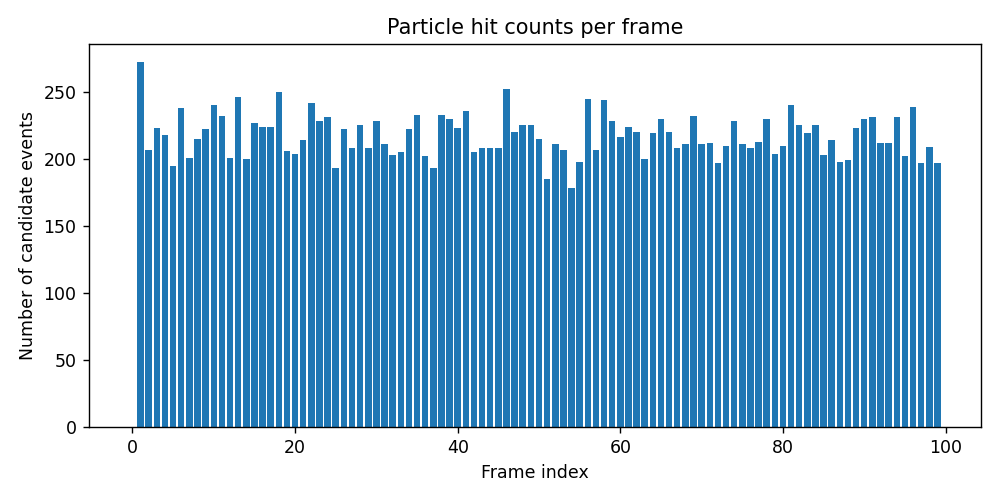

In [4]:
sigma_thresh   = 20.0
mask_expanded  = maximum_filter(maskArray.astype(int), size=5) > 0

def find_peaks_for_frame(iframe, sigma_thresh):
    image   = data[iframe]
    _, med, _ = sigma_clipped_stats(image, sigma=3.0, maxiters=5)
    mad     = np.median(np.abs(image - med))
    sigma_e = mad * 1.4826
    threshold = med + sigma_thresh * sigma_e

    local_max = maximum_filter(image, size=3)
    cand      = (image == local_max) & (~mask_expanded) & (image > threshold)

    ys, xs = np.where(cand)
    peaks  = [(iframe, int(y), int(x)) for y, x in zip(ys, xs)]
    return peaks, threshold

if __name__ == "__main__":
    Nframe = data.shape[0]

    # 1) run in parallel, get a list of (peaks, threshold) tuples
    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(
            find_peaks_for_frame,
            range(Nframe),
            [sigma_thresh] * Nframe
        ))

    # 2) unzip them into two lists
    all_frame_peaks, thresholds = zip(*results)
    #    all_frame_peaks is a tuple of length Nframe, each entry is the peaks list
    #    thresholds        is a tuple of length Nframe, each entry is that frame’s threshold

    # 3) now do your “previous‐frame” filtering exactly as before
    filtered_events = []
    for f, peaks in enumerate(all_frame_peaks):
        prev_f = (f - 1) % Nframe
        prev_pos = {(y, x) for (_, y, x) in all_frame_peaks[prev_f]}
        for (_, y, x) in peaks:
            if (y, x) not in prev_pos:
                filtered_events.append((f, y, x))

    events = np.array(filtered_events, dtype=int)
    print(f"Found {len(events)} xray & cosmic‐ray‐like peaks "
          f"with ≥{sigma_thresh:.1f} σ cut (per-frame thresholds below):")

    # 4) if you want, print out each frame’s threshold:
    #for f, thr in enumerate(thresholds):
        #print(f"  frame {f:3d}: threshold = {thr:.1f}")

        # count how many hits in each frame
counts = np.bincount(events[:,0], minlength=data.shape[0])

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(counts)), counts)
plt.xlabel("Frame index")
plt.ylabel("Number of candidate events")
plt.title("Particle hit counts per frame")
plt.tight_layout()
plt.show()

In [5]:
low_threshold = 0.5 * sigma_thresh

# Freudenburg et al. gain
gain = 1.6232  # electrons per DN

# Dimensions
Nframe, H, W = data.shape

def prep_frame(f):
    """Compute median background, sigma_est, and labels for frame f."""
    img = data[f].astype(np.float64)
    _, med, _ = sigma_clipped_stats(img, sigma=3.0, maxiters=5)
    mad       = np.median(np.abs(img - med))
    sigma_est = mad * 1.4826
    thresh    = med + low_threshold * sigma_est
    labels_fp, _ = label(img > thresh)
    return f, med, labels_fp

def process_hit(hit):
    """Given one (f, y, x) hit, compute all sums and return a dict."""
    f, y, x      = hit
    img          = data[f].astype(np.int32)
    med          = medians[f]
    labels_fp    = labels_list[f]

    # 3×3 window
    y0,  y1     = max(y-1,0), min(y+2,H)
    x0,  x1     = max(x-1,0), min(x+2,W)
    sum3        = img[y0:y1, x0:x1].sum()

    # 5×5 window
    y0_5, y1_5 = max(y-2,0), min(y+3,H)
    x0_5, x1_5 = max(x-2,0), min(x+3,W)
    sum5        = img[y0_5:y1_5, x0_5:x1_5].sum()

    # footprint sum
    lab         = labels_fp[y, x]
    region      = (labels_fp == lab)
    sum_fp_DN   = img[region].sum() - med * region.sum()

    return {
        'frame':      f,
        'y':          y,
        'x':          x,
        'sum3x3_DN':  int(sum3),
        'sum3x3_e⁻':  sum3 * gain,
        'sum5x5_DN':  int(sum5),
        'sum5x5_e⁻':  sum5 * gain,
        'fp_label':   lab,
        'fp_DN':      int(sum_fp_DN),
        'fp_e⁻':      sum_fp_DN * gain,
        'n_pix_fp':   int(region.sum()),
    }

if __name__ == '__main__':
    # 1) Parallel frame prep
    medians     = np.zeros(Nframe, dtype=float)
    labels_list = [None] * Nframe

    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(prep_frame, f) for f in range(Nframe)]
        for fut in as_completed(futures):
            f, med, labels_fp = fut.result()
            medians[f]    = med
            labels_list[f] = labels_fp

    # 2) Parallel hit processing
    rows = []
    with ProcessPoolExecutor(max_workers=8) as executor:
        # adjust n_workers = os.cpu_count() if you like
        for result in executor.map(process_hit, events):
            rows.append(result)

    # 3) Build DataFrame & plot
    df = pd.DataFrame(rows)
    print(df.head())


   frame   y     x  sum3x3_DN  sum3x3_e⁻  sum5x5_DN  sum5x5_e⁻  fp_label  \
0      1  13  3861       1462  2373.1184       1478  2399.0896        20   
1      1  33  1515        625  1014.5000        614   996.6448        50   
2      1  37  3716       1552  2519.2064       1553  2520.8296        55   
3      1  51  1291       1427  2316.3064       1381  2241.6392        83   
4      1  57  3787       1489  2416.9448       1466  2379.6112        92   

   fp_DN      fp_e⁻  n_pix_fp  
0   1263  2050.1016         2  
1    578   938.2096         2  
2   1488  2415.3216         3  
3   1440  2337.4080         4  
4   1402  2275.7264         3  


<IPython.core.display.Javascript object>


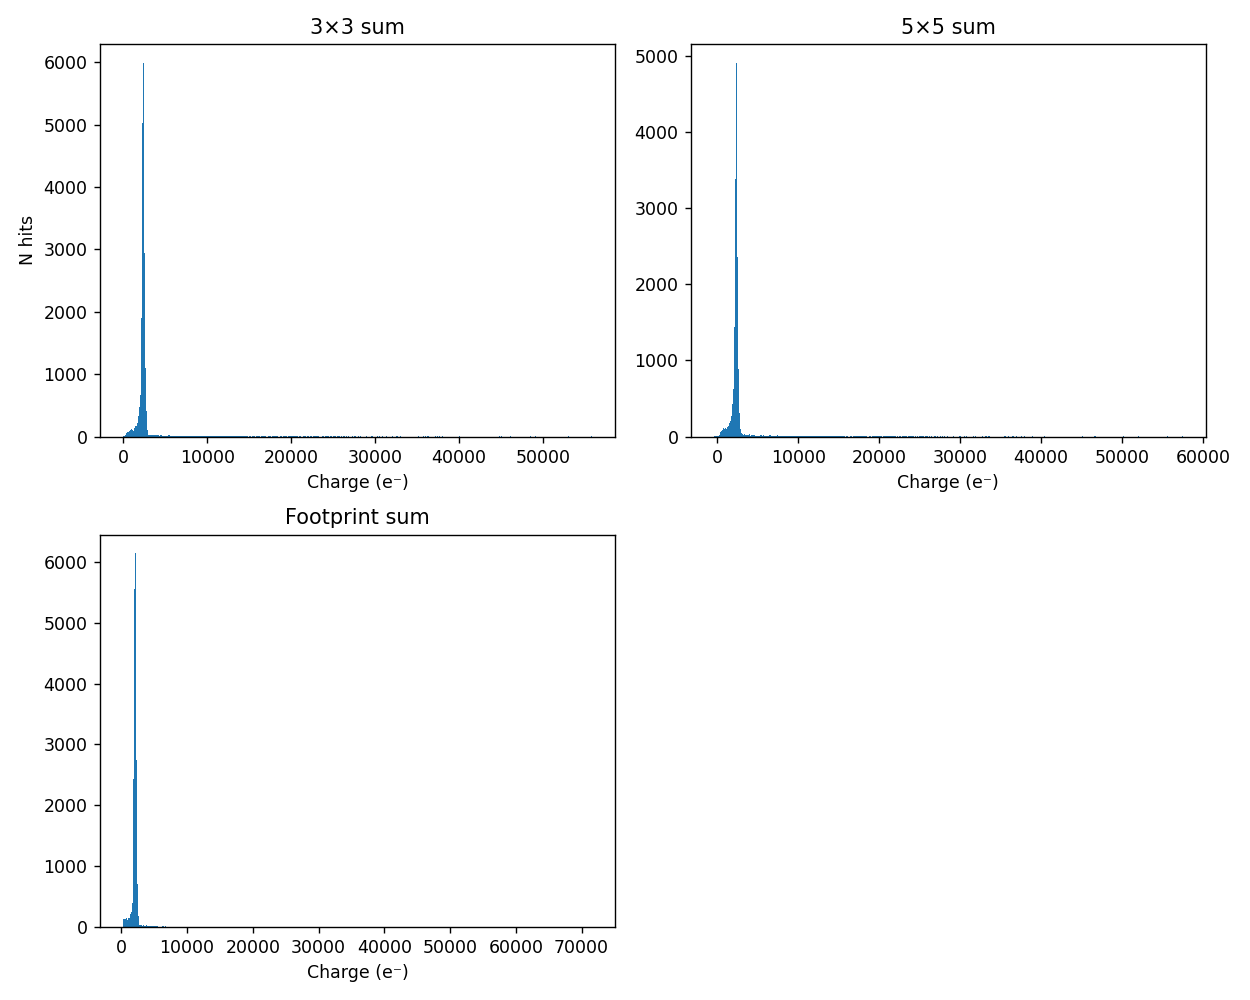

In [6]:
# --- 4) Plot histograms in 2 rows × 2 cols ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()   # makes it easy to index: axes[0], axes[1], axes[2], axes[3]

# 3×3 sum
axes[0].hist(df['sum3x3_e⁻'], bins=500)
axes[0].set(title='3×3 sum', xlabel='Charge (e⁻)', ylabel='N hits')

# 5×5 sum
axes[1].hist(df['sum5x5_e⁻'], bins=500)
axes[1].set(title='5×5 sum', xlabel='Charge (e⁻)')

# Footprint sum
axes[2].hist(df['fp_e⁻'], bins=500)
axes[2].set(title='Footprint sum', xlabel='Charge (e⁻)')

# Turn off the empty fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


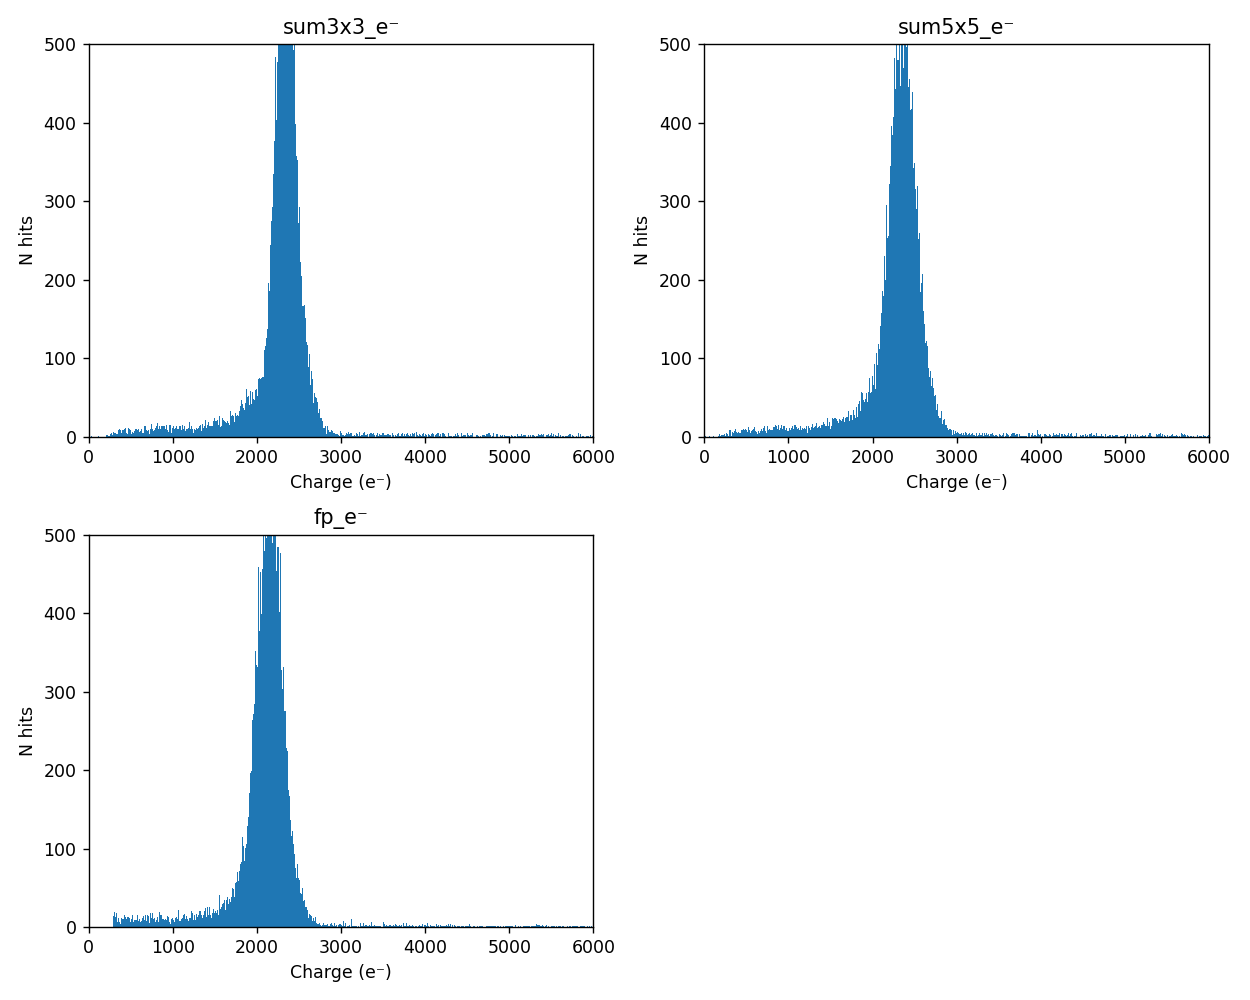

In [7]:
# define your desired x– and y–limits
x_min, x_max = 0, 6000
y_min, y_max = 0, 500

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# first three plots, each clipped to [0,2000] on x and [0,100] on y
for ax, col in zip(axes[:3], ['sum3x3_e⁻', 'sum5x5_e⁻', 'fp_e⁻']):
    ax.hist(df[col], bins=500, range=(x_min, x_max))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Charge (e⁻)')
    ax.set_ylabel('N hits')
    ax.set_title(col)

# turn off the empty fourth subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#fit a gaussian to the histograms

In [ ]:
inspect_frame = 61

# 1) grab the image and build your RGB mask as before
img = data[inspect_frame]
h, w = mask_med.shape
rgb_mask = np.zeros((h, w, 3), dtype=float)
rgb_mask[..., 0] = mask_med.astype(float)
rgb_mask[..., 1] = mask0.astype(float)
rgb_mask[..., 2] = mask_sat.astype(float)

# ← DELETE steps 2+3 entirely ←

# Instead just fetch:
median    = medians[inspect_frame]
labels_fp = labels_list[inspect_frame]

# 4) select only the hits in this frame
mask_frame = (events[:, 0] == inspect_frame)
ys, xs     = events[mask_frame, 1], events[mask_frame, 2]

# 5) plot: image, RGB masks, then contours of each strike’s full footprint
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap='gray', origin='lower')
ax.imshow(rgb_mask, origin='lower', alpha=0.5)

for y, x in zip(ys, xs):
    lab = labels_fp[y, x]
    if lab == 0:
        continue
    region = (labels_fp == lab)
    ax.contour(
        region.astype(int),
        levels=[0.5],
        colors='white',
        linewidths=1.5,
        origin='lower'
    )

# 6) re-plot centroids on top, add legend, etc.
ax.scatter(
    xs, ys,
    s=20,
    facecolors='none',
    edgecolors='red',
    label=f"{len(xs)} hits"
)
ax.set_title(f"Frame {inspect_frame}: full-footprint outlines")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
def get_cr_hits_for_frame(df, frame_idx):
    """
    Return a DataFrame of all cosmic-ray hits in a given frame.

    Parameters
    ----------
    df : pandas.DataFrame
        Your full table with at least a 'frame' column.
    frame_idx : int
        The frame number you want to filter on.

    Returns
    -------
    pandas.DataFrame
        Subset of df where df['frame'] == frame_idx, with a fresh index.
    """
    sub = df[df['frame'] == frame_idx].copy()
    return sub.reset_index(drop=True)

# Suppose df is your full CR-hit table:
inspect_frame = 61
hits_from_frame = get_cr_hits_for_frame(df, inspect_frame)
print(hits_from_frame)


In [ ]:
df_unique = df.drop_duplicates(subset=['frame','fp_label'])

print("Original dataframe had ",len(df)," candidate entries")
difference = len(df) - len(df_unique)
print("New dataframe has ",len(df_unique)," candidate entries,", difference, " were duplicates")

plt.figure(figsize=(10,8))
plt.hist(df_unique['fp_e⁻'], bins=500)
plt.xlabel('Charge (electrons)')
plt.ylabel('Number of footprints')
plt.title('Histogram of unique footprint charges')
plt.tight_layout()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()


In [ ]:
# 1) Build df_unique (one row per footprint)
#    Make sure your original df has a column 'fp_label'
#df_unique = df.drop_duplicates(subset=['frame','fp_label'])

# 2) Compute centroids of each footprint
centroids = (
    df_unique
      .groupby(['frame','fp_label'])
      .agg(x_centroid=('x','mean'),
           y_centroid=('y','mean'))
      .reset_index()
)

In [ ]:
# 1) Using direct indexing
#df_filtered = df[df['n_pix_fp'] > 10]

# 2) Using .loc
#df_filtered = df.loc[df['n_pix_fp'] > 10]

# 3) Using .query
#df_filtered = df.query('n_pix_fp > 10')

#df_filtered = df_filtered.reset_index(drop=True)

# 1a) filter and copy
df_filtered = df_unique[df_unique['n_pix_fp'] > 10].copy()

# 1b) now it’s safe to sort in place
df_filtered.sort_values('n_pix_fp', ascending=False, inplace=True)

# (optional) reset index
#df_filtered.reset_index(drop=True, inplace=True)
df_filtered.head(20)

In [ ]:
inspect_frame = 61

# 3) Select only this frame’s footprints
sel = centroids['frame'] == inspect_frame
frame_centroids = centroids.loc[sel]

# 4) Grab image & RGB mask
img = data[inspect_frame]
h, w = mask_med.shape
rgb_mask = np.zeros((h, w, 3), dtype=float)
rgb_mask[..., 0] = mask_med.astype(float)
rgb_mask[..., 1] = mask0.astype(float)
rgb_mask[..., 2] = mask_sat.astype(float)

# 5) Fetch precomputed background & labels
median    = medians[inspect_frame]
labels_fp = labels_list[inspect_frame]

# 6) Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img,      cmap='gray', origin='lower')
ax.imshow(rgb_mask, origin='lower', alpha=0.5)

# contours of each unique footprint
for lab in frame_centroids['fp_label']:
    if lab == 0:
        continue
    region = (labels_fp == lab)
    ax.contour(
        region.astype(int),
        levels=[0.5],
        colors='white',
        linewidths=1.5,
        origin='lower'
    )

# scatter the centroids
ax.scatter(
    frame_centroids['x_centroid'],
    frame_centroids['y_centroid'],
    s=40,
    facecolors='none',
    edgecolors='red',
    label=f"{len(frame_centroids)} footprints"
)

ax.set_title(f"Frame {inspect_frame}: unique full-footprint outlines")
ax.set_xlabel("X pixel")
ax.set_ylabel("Y pixel")
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()
